# CS109b Project Milestone 5: Appendix Notebook
### Mads Groeholdt, Sean McCabe, Josie Mobley, Bridget Sands

## About:

This notebook is to act as an appendix notebook to our final submission notebook. As detailed in our main final notebook, because of the complexity of our preprocessing, we did not think it made sense to put the initial model we developed- though still significant- in our main submission notebook. Therefore, for simplicity, we put some of the earlier exploration EDA and our baseline model in this notebook, an adaption of our milestone 4 notebook submission.


### **tl;dr**: This notebook holds both **Early EDA Exploration and Visualizations** as well as our **Baseline Model**.

## Table of Contents:
1. [Import Necessary Libraries](#first-bullet)
2. [Read in, Inspect, and Split Data](#second-bullet)
   1. [Read in Data](#read)
   2. [Inspect Data](#inspect)
   3. [Split Data](#split)
3. [Visually Inspect Raw Data](#vizraw)
4. [Augment Training Data](#aug)
5. [Further Preprocess Data](#fpp)
    1. [Trim Files](#trim)
    2. [Pad Files](#pad)
    3. [Encode Categories](#encode)
6. [Convert to Mel Spectrogram](#mel)
7. [Baseline Mel Spectrogram Model](#base)
8. [Takeaways/Notebook Conclusions](#take)

## 1: Import Necessary Libraries: <a class="anchor" id="first-bullet"></a>

Below we begin our notebook by reading in libraries used in later code.

In [26]:
import numpy as np
import librosa
import os
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, Flatten, Input,Dense, MaxPooling2D, Dropout

## 2: Read in, Inspect, and Split Data: <a class="anchor" id="second-bullet"></a>
### 2a: Read in Data (mp3 -> np.array) <a class="anchor" id="read"></a>
Here we read in our data that we got from the original source. We make an effort to iterate through such data to disregard previously augmented data, as we intend (and later do) create our own augmnented data. We utilize the librosa library to read in the data, as it is able to convert mp3 files to np arrays, converting audio files into numeric representations.

In [27]:
%%time
# Initialize time, features, labels
features = []
labels = []

# Define file path
path = 'final_project_data/data/'

# Helper function to throw out augmented files
def is_raw_mp3(file_name):
    return bool(re.search(r'\.mp3$', file_name) and not re.search(r'_aug1\(1\)\.mp3$', file_name))

# Fix sampling rate at 16 kHz
sr = 16000

# Intialize probabilities
probs = []
# Iterate through files to properly read in data
for subdir, dirs, files in os.walk(path):
    for file in files:
        filepath = os.path.join(subdir, file)
        class_label = os.path.basename(subdir)
        if not is_raw_mp3(filepath):
            continue
        audio, _ = librosa.load(filepath, sr=sr)
        #print(audio)
        features.append(audio)
        labels.append(class_label)

Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


CPU times: user 10.3 s, sys: 574 ms, total: 10.9 s
Wall time: 12.5 s


### 2b: Inspect data <a class="anchor" id="inspect"></a>
Here we briefly inspect and check the number of labels each classification category has in the data. We want to ensure that the data overall is balanced relative to classes so the model is not trained with bias towards one category.

As displayed in the output below, the categories are roughly uniformly represented in our data, with about ~300 labels for each of the ten labels.

In [28]:
# Count and print out labels for each category
label_counts = Counter(labels)
print('Label counts for entire dataset - we see that it is balanced')
formatted_string = '\n'.join([f"{label}: {count}" for label, count in label_counts.items()])
print(formatted_string)

Label counts for entire dataset - we see that it is balanced
Paining: 291
Defence: 291
Happy: 297
Mating: 301
Angry: 300
HuntingMind: 289
Fighting: 300
MotherCall: 296
Resting: 296


### 2c: Split Data <a class="anchor" id="split"></a>
Here we split the data into training and validation sets. Following the split, we print out the number of files in the training and test sets. Just as we did with the overall data, following our split we ensure that the categories are relatively balanced in the train and test set.

**Note:** This practice of splitting the data into training and test sets at the beginning is **different** than what we did in our other main notebook. Such differences in process created notebook complexity and was motivation for the separation of methods.

In [29]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Print size of subsets
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 2368 samples
Testing set size: 593 samples


In [30]:
# Count and Print the labels of the training set
train_label_counts = Counter(y_train)
print('Label counts for train set:')
formatted_string = '\n'.join([f"{label}: {count}" for label, count in train_label_counts.items()])
print(formatted_string)

Label counts for train set:
Defence: 222
Resting: 231
Mating: 248
HuntingMind: 239
Paining: 225
Happy: 241
Fighting: 254
MotherCall: 232
Angry: 249


In [31]:
# Count and Print the labels of the test set
test_label_counts = Counter(y_test)
print('Label counts for test set:')
formatted_string = '\n'.join([f"{label}: {count}" for label, count in test_label_counts.items()])
print(formatted_string)

Label counts for test set:
Angry: 51
Resting: 65
Happy: 56
HuntingMind: 50
Defence: 69
Fighting: 46
MotherCall: 64
Paining: 66
Mating: 53


## 3. Visualize Raw Data <a class="anchor" id="vizraw"></a>
In the following code we visualize the raw data in the form that it was read in by the librosa library. We visualize a single example for each of the ten classes. To do this we first separate the first instance of each class within the training data.

As you can see in the displayed subplots, there is a lot of variation between the samples from different classes. The size of the amplitude, the patterns in amplification, and the time length are unique. To better analyze the samples in relation to one another, and to ensure uniform input into our models, we pad our recordings with zeros. We pad all samples, train, and test, to the longest recording in the dataset, retaining the original audio signal's temporal structure without altering its content, visualized for the 10 samples below. 

In [32]:
# Locate and isolate first instance of each class
unique_classes = set(y_train)
sampled_indices = []
for cls in unique_classes:
    for idx, label in enumerate(y_train):
        if label == cls:
            sampled_indices.append(idx)
            break  

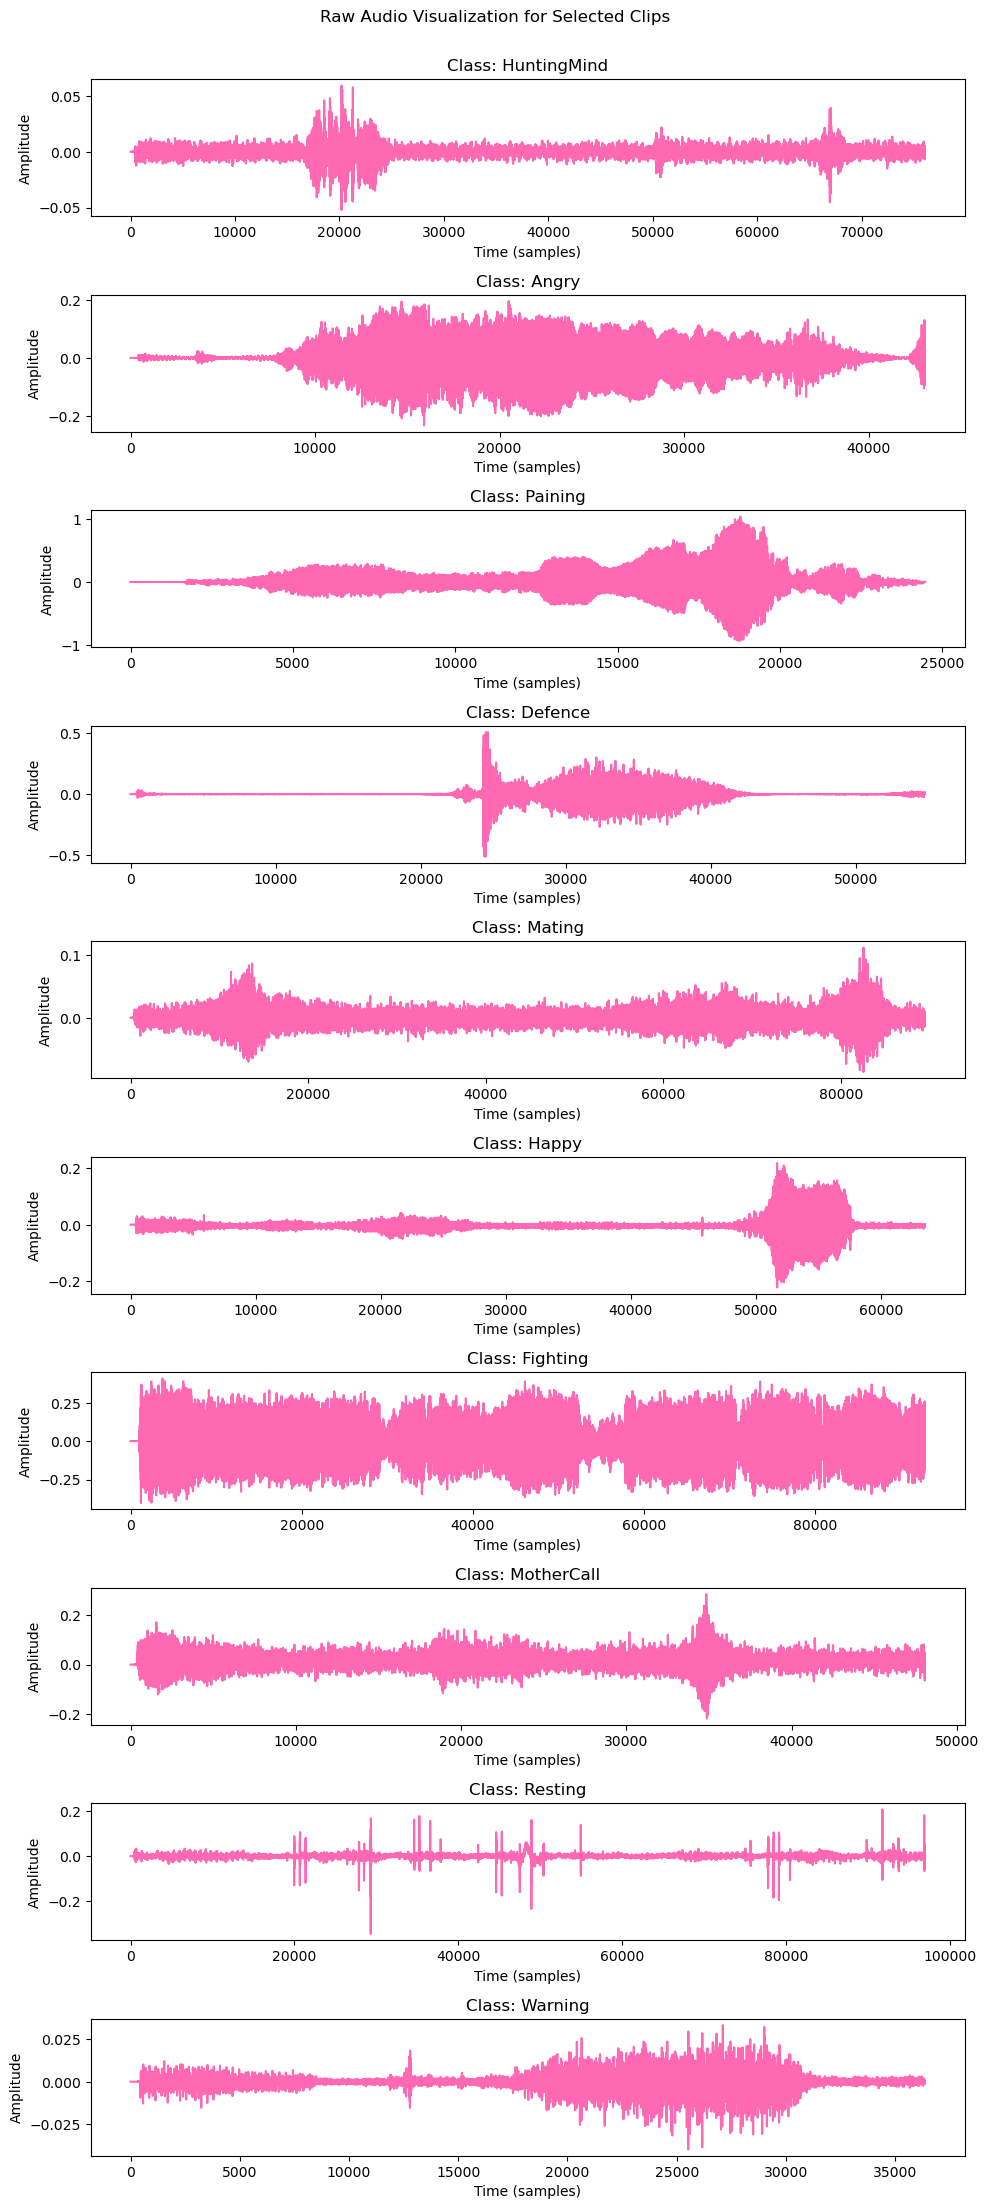

In [33]:
# Create plots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 22))
plt.suptitle('Raw Audio Visualization for Selected Clips', y=1.002)

# Iterate through each class and print plot
for i, idx in enumerate(sampled_indices):
    axes[i].plot(X_train[idx], color='hotpink')
    axes[i].set_title(f'Class: {y_train[idx]}')
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

# Adjust the layout
plt.tight_layout()
plt.show()

## 4: Augment Training Data <a class="anchor" id="aug"></a>
In the following code, we augment the training data. We do this because as output from checking the original data shows, the number of files in the dataset is relatively small. Therefore, we decided to augment the training data, or rather transform the training data we already have into additional samples to increase the number of files in our training set. As output below, following the augmentation of our data, our training set increased from ~2,400 examples to ~9,500 samples. Note that the second cell below takes an elogated time to run. 

In [34]:
# Augmenter for training data
augmenter = Compose([
        # speed change between 0.9 and 1
        TimeStretch(min_rate=0.9, max_rate=1.0, p=0.5),
        # pitch shift between -4 and 4
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        # gaussian noise
        AddGaussianNoise(min_amplitude=0.1, max_amplitude=0.5, p=0.5),
        # time shift within 20% of original clip
        Shift(min_shift=-0.2, max_shift=0.2, shift_unit='fraction', p=0.5),
    ])

In [35]:
%%time
# Augment training data to create additional samples
def augment_training(features, labels, n_augment, augmenter=augmenter):
    augment_features = []
    augment_labels = []
    for feature, label in zip(features, labels):
        for _ in range(n_augment):
            augmented = augmenter(samples = feature, sample_rate = sr)
            #augmented.reshape(
            augment_features.append(augmented)
            augment_labels.append(label)
    features.extend(augment_features)
    labels.extend(augment_labels)
    return features, labels

# Call function, print new info
X_train_aug, y_train_aug = augment_training(X_train, y_train, 3, augmenter)
print(f'X train now has {len(X_train_aug)} samples including augmented')

X train now has 9472 samples including augmented
CPU times: user 59.2 s, sys: 968 ms, total: 1min
Wall time: 1min


## 5: Further Preprocess Data <a class="anchor" id="fpp"></a>
### 5a: Trim Files <a class="anchor" id="trim"></a>
As mentioned briefly, following our previous milestones, we discovered a great variance in the lengths of the files, which is quite problematic. Because of such concerns we further decided to investigate the lengths of all files in our set, as shown in the histograms below. By plotting the distribution of the file lengths, we were able to recognize that the file lengths of both the training and testing sets were distributed relatively normally, however both sets had a few outliers that forced a slight right skew. To adjust for this, we created a maximum length for the distributions of a 150,000 sequence length. We enforced this cut off to make the length distributions more normal, but also because longer maximum lengths would have created even more parameters to train our models on, as we pad the lengths under the maximum in standardization- by doing this we reduce computational complexity.

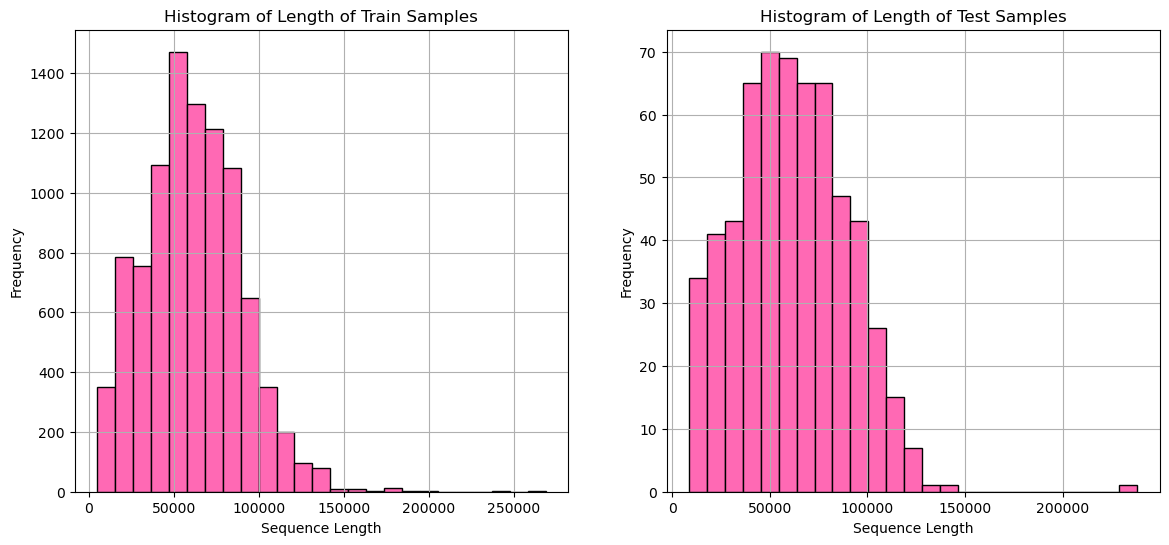

In [36]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs = axs.ravel()

# Initialize length lists
lengths = []
lengths_test = []
# Iterate through files and record lengths
for arr in X_train_aug:
    lengths.append(len(arr))
for arr in X_test:
    lengths_test.append(len(arr))

# Plot training length distribution
axs[0].hist(lengths, bins=25, edgecolor='black', color='hotpink')
axs[0].set_title('Histogram of Length of Train Samples')
axs[0].set_xlabel('Sequence Length')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot testing length distribution
axs[1].hist(lengths_test, bins=25, edgecolor='black', color='hotpink')
axs[1].set_title('Histogram of Length of Test Samples')
axs[1].set_xlabel('Sequence Length')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

In [37]:
# Create max length
MAX_LENGTH = 150000

# Print number of samples over max length 
print(f'The number of dropped samples in the train data are {len([elem for elem in lengths if elem > MAX_LENGTH])}')
print(f'The number of dropped samples in the train data are {len([elem for elem in lengths_test if elem > MAX_LENGTH])}')

# Define trimming helper function
def trim_list(x_lst, y_lst, lengths):
    trimmed_idx = [i for i, x in enumerate(lengths) if x > MAX_LENGTH]
    trimmed_x = [x for i, x in enumerate(x_lst) if i not in trimmed_idx]
    trimmed_y = [y for i, y in enumerate(y_lst) if i not in trimmed_idx]
    return trimmed_x, trimmed_y
    
# Trim sets
X_train_trimmed, y_train_trimmed = trim_list(X_train_aug, y_train_aug, lengths)
X_test_trimmed, y_test_trimmed = trim_list(X_test, y_test, lengths_test)

The number of dropped samples in the train data are 40
The number of dropped samples in the train data are 1


### 5b: Pad Files <a class="anchor" id="pad"></a>

Now, in order to make all of the files in our set the same size- 150,000 sequences long- we pad all with zeroes. By padding, we make all files in both of our sets the same sequence length. We have previously defined this to be the maximum 150,000 sequence length. If any file in the set is less than 150,000 in sequence length, zeros are added as "padding" to the file in order to make it equal to the maximum 150,000 length. This is done for computation. 

After we add the padding, we visualize an example of each of the categories raw files. As seen in the subplots below, all ten of the different examples (one for each category) have the same sequence length (150,000). In a previously submitted milestone, our plots had 250,000 sequence lengths- we reduced the size, as mentioned above, because of the set length distributions in order to same computation complexity. We did not find issues with this reduction upon later consideration.

In [38]:
%%time
# Function to pad to a single length, the maximum input length from the dataset
def pad(signals, target_length):
    padded = []
    for file in signals:
        cur_length = len(file)
        if cur_length == target_length:
            padded.append(file)
            continue
        total_padding = target_length - cur_length
        if total_padding < 0:
            # truncate if file is too long(this should never happen by construction)
            padded.append(file[:target_length])
            continue
        # handling parity
        pad_before = total_padding // 2
        pad_after = total_padding - pad_before
        padded_signal = np.pad(file, (pad_before, pad_after), mode='constant', constant_values=0)
        padded.append(padded_signal)
    return padded

# Call function
X_train_padded = pad(X_train_trimmed, MAX_LENGTH)
X_test_padded = pad(X_test_trimmed, MAX_LENGTH)

CPU times: user 256 ms, sys: 653 ms, total: 908 ms
Wall time: 1.24 s


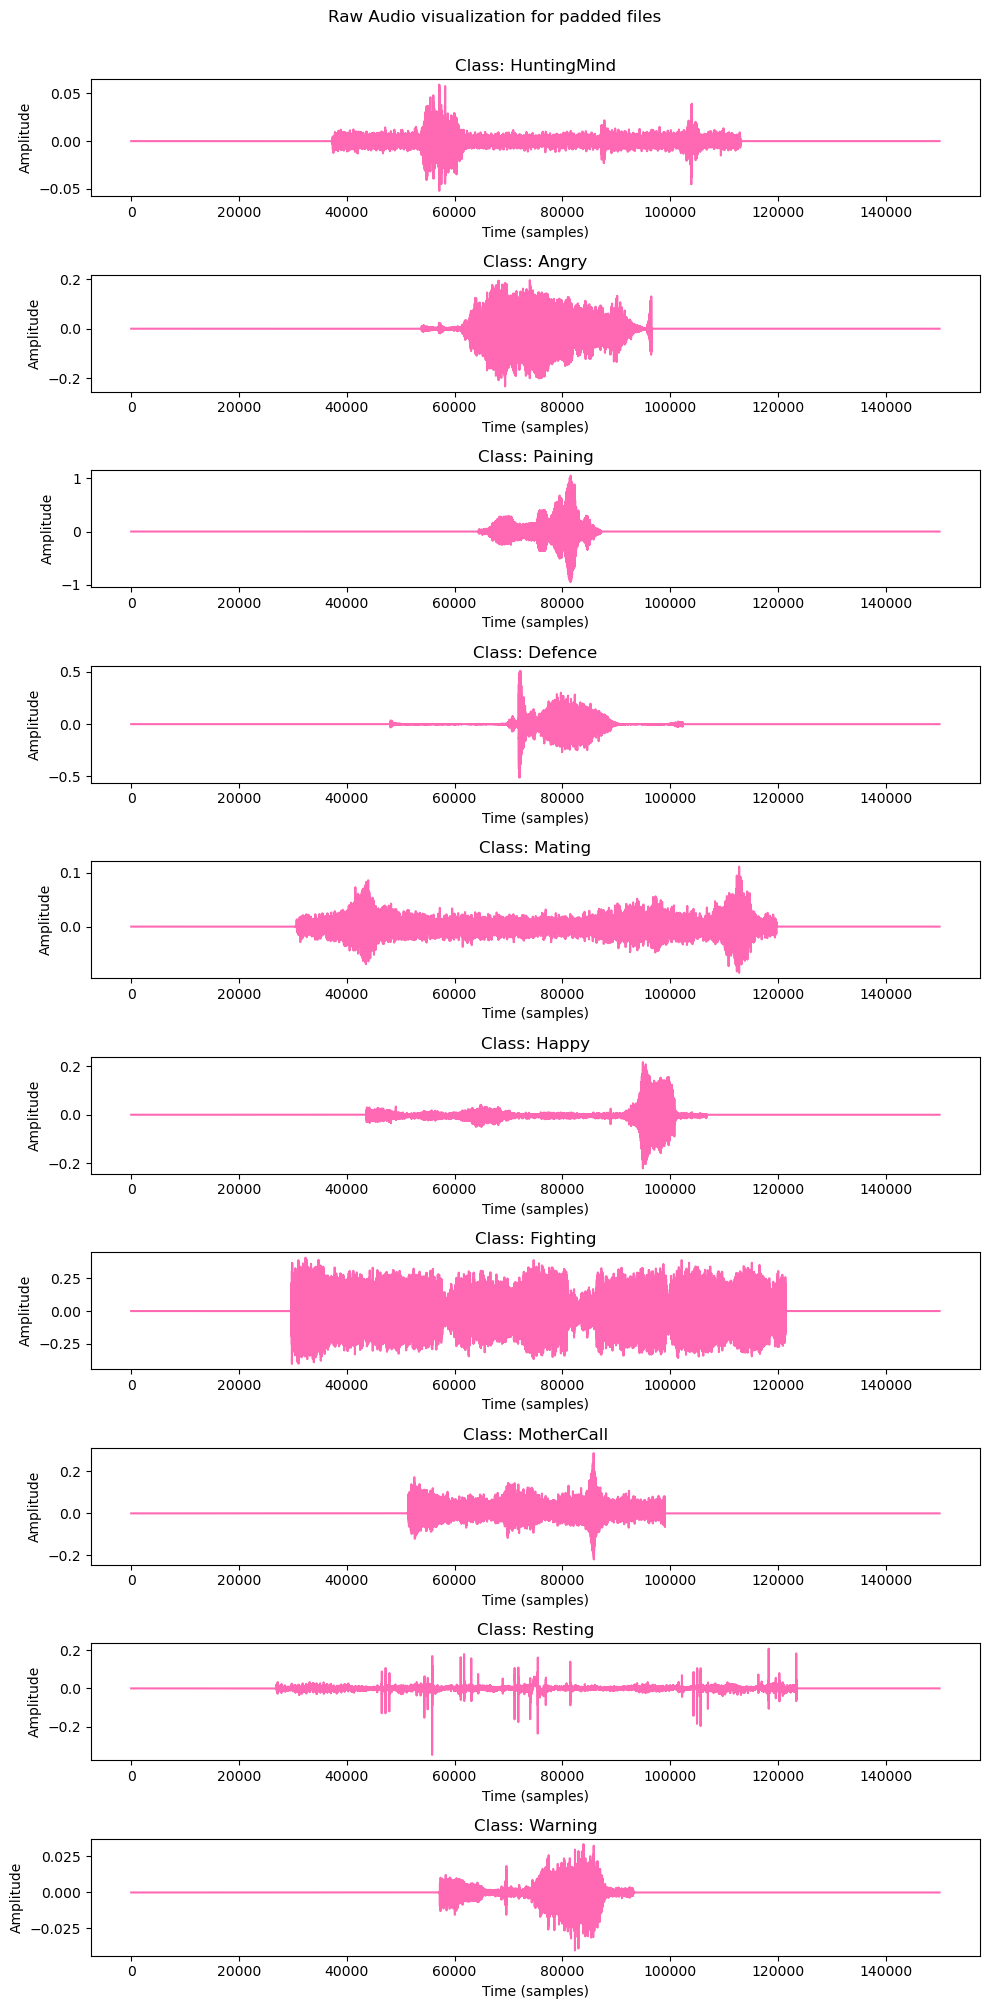

In [39]:
# Create subplots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

# Plot
plt.suptitle('Raw Audio visualization for padded files', y = 1.002)
for i, idx in enumerate(sampled_indices):
    axes[i].plot(X_train_padded[idx], color='hotpink')
    axes[i].set_title(f'Class: {y_train_trimmed[idx]}')
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

# Adjust the layout
plt.tight_layout()
plt.show()

### 5c: Encode Categories <a class="anchor" id="encode"></a>
The default y variables are string labels for each of the ten emotions. However, to pass the labels of the data set into a model we need to convert them into numerical representations. The code below does the transformation, and then prints out the corresponding string and number label pairings for both the training and test sets.

In [40]:
# Dictionary for categorical to numerical translation
unique_categories = list(set(y_train_trimmed))
category_to_numerical = {category: i for i, category in enumerate(unique_categories)}

# Dictionary for numerical to categorical translation
numerical_to_category = {i: category for i, category in enumerate(unique_categories)}

In [41]:
# Helper function for translation
def categorical_to_numerical(categories):
    numerical_array = [category_to_numerical[category] for category in categories]
    return numerical_array, unique_categories

# Call function
y_train_trimmed, unique_categories = categorical_to_numerical(np.array(y_train_trimmed))
y_test_trimmed, unique_cats = categorical_to_numerical(np.array(y_test_trimmed))

In [42]:
# Print number and string categories for both train and test
print([numerical_to_category[y] for y in y_train_trimmed[0:10]])
print(y_train_trimmed[0:10])
print([numerical_to_category[y] for y in y_test_trimmed[0:10]])
print(y_test_trimmed[0:10])

['Defence', 'Resting', 'Defence', 'Mating', 'HuntingMind', 'HuntingMind', 'Warning', 'Mating', 'Warning', 'Warning']
[3, 8, 3, 4, 0, 0, 9, 4, 9, 9]
['Angry', 'Angry', 'Resting', 'Happy', 'Resting', 'Happy', 'HuntingMind', 'Happy', 'Angry', 'Defence']
[1, 1, 8, 5, 8, 5, 0, 5, 1, 3]


## 6: Convert Data to Mel Spectrogram <a class="anchor" id="mel"></a>
In the following code, we convert our data into Mel Spectrogram forms. We do this by again utilizing the librosa library. Our intention in this is following the same process the paper our project is based off of, as they also translated the original data by utilizing Mel Spectrograms. Using the fast Fourier transformation, this brings the recordings into the frequency domain and represents the samples as 2D arrays, with one axis representing time and one representing frequencies, highlighting the spectral content of the recordings over time and making the format suitable for use as models  inputs. 

Folowing the Mel Spectrogram transformations we again visualize a sample of each of the class categories. As shown in the below spectrograms, no two of the 10 examples are exactly alike. There are significant differences in length, frequency, and emphasis. This bodes well for our intentions to train a model to label the different emotions.

In [43]:
%%time
# Define conversion helper function
def convert_to_mel(audio_signals, sample_rate=sr, n_mels=96, n_fft=2048, hop_length=256):
    mel_spectrograms = []
    for signal in audio_signals:
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spectrograms.append(mel_spec_db)
    return mel_spectrograms

# Call function
X_train_mel = convert_to_mel(X_train_padded)
X_test_mel = convert_to_mel(X_test_padded)

CPU times: user 2min 51s, sys: 3.04 s, total: 2min 54s
Wall time: 1min 3s


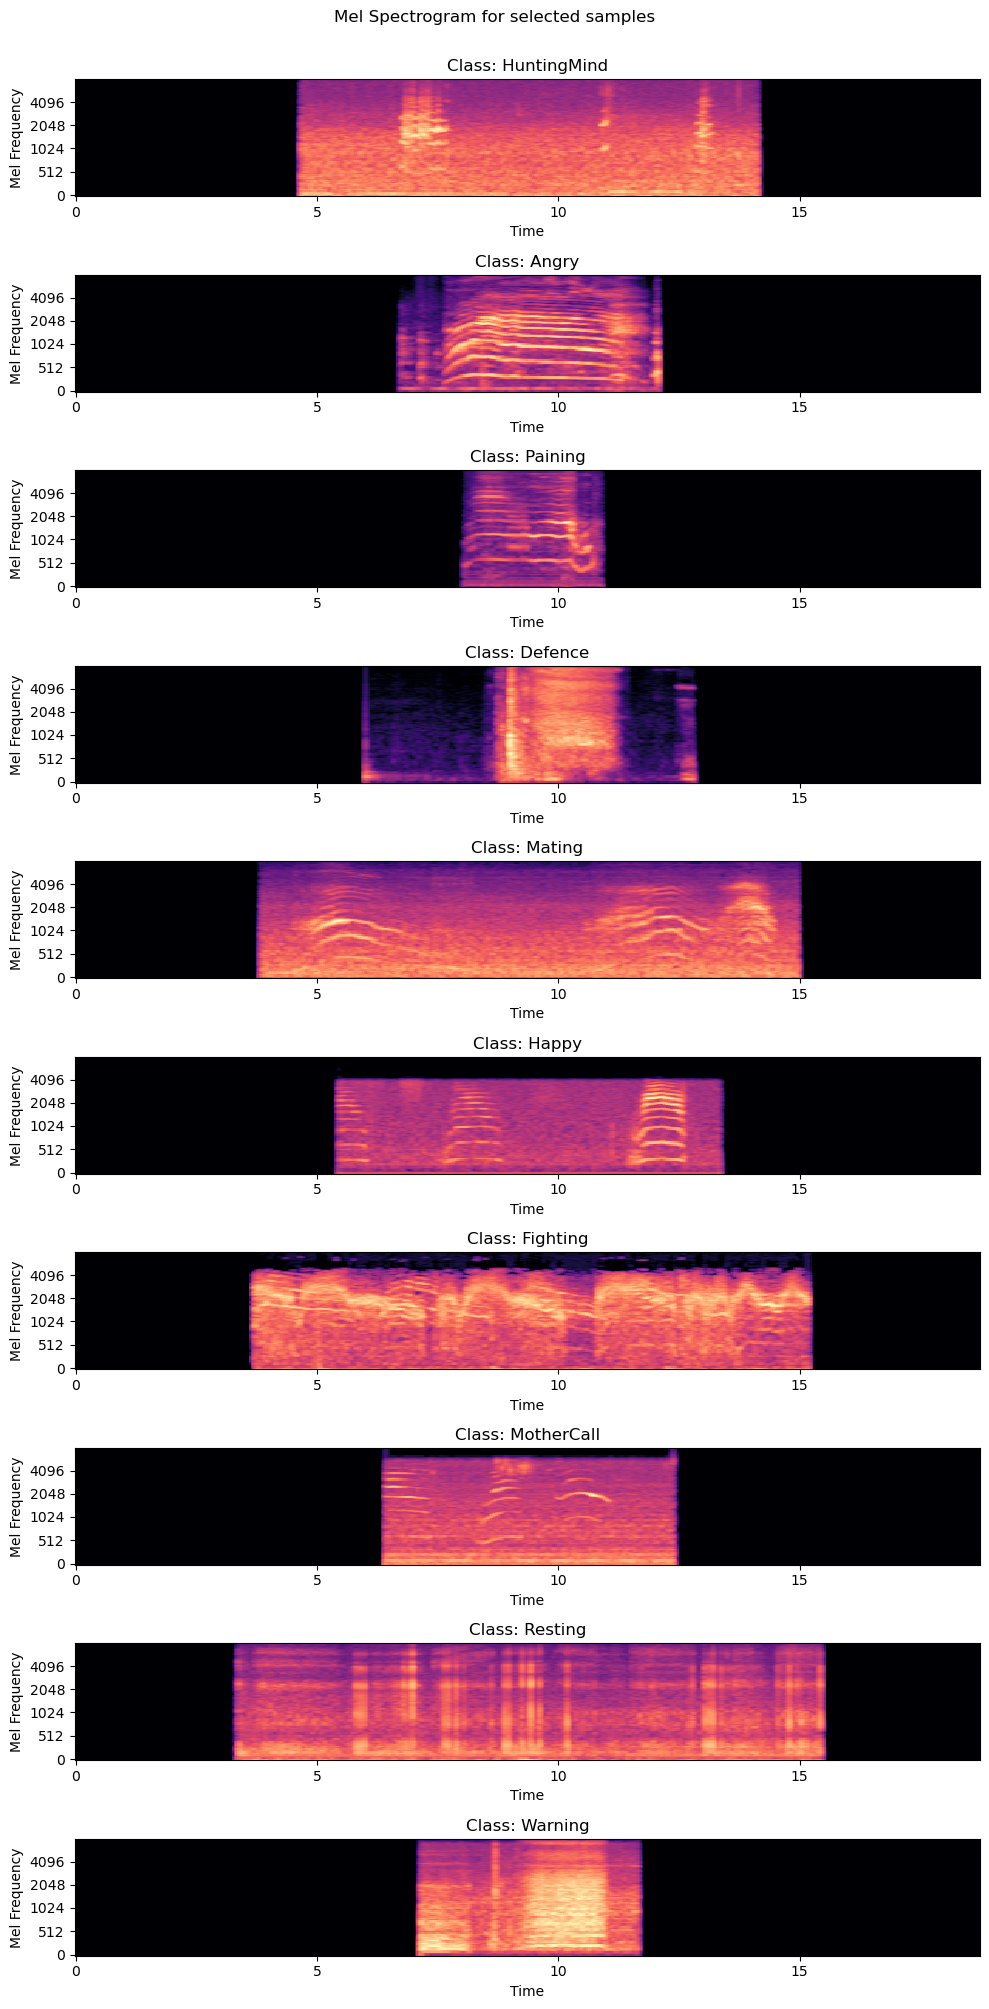

In [44]:
# Create plots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
axes.flatten()
plt.suptitle('Mel Spectrogram for selected samples', y = 1.002)

# Plot each mel spectrogram and set the title
for i, idx in enumerate(sampled_indices):
    librosa.display.specshow(X_train_mel[idx], ax=axes[i], sr=16000, x_axis='time', y_axis='mel', hop_length=512)
    axes[i].set_title(f'Class: {numerical_to_category[y_train_trimmed[idx]]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()

## 7: Baseline Mel Spectrogram Model <a class="anchor" id="base"></a>
Our first baseline model is a Convolutional Neural Network. It is a very basic- Pavlos might call it "Vanilla"- version of a CNN. It has a single 2D convolutional layer and max pooling layer, with two dense layers and a drouput layer. 

We struggled a bit to get the data in the proper form that a model would take as an input- revising code (all changes included above). Therefore, our intention was to make as basic of a benchmark model as we could. In the paper we are following, they created a CNN based on the cat data as well as used a publically available CNN for further transfer learning. Thus, our model reflected below is a simple CNN- we are planning on further developing it and comparing it back to this benchmark later.

In the code below, we first adjusted the shape of the training set in order to make it ready to be inputted into the model. We then defined the model architecture, as I briefly defined above. The NN's layers, their output shapes, as well as the parameters they require to be trained are displayed below.

We compiled the CNN model using the adam optimizer, fitting with sparse categorical cross entropy as a loss function, as we are considering more than two categories. We trained with four epochs (after visually inspecting and testing others), with a generally standard 64 batch size. We further used a 20% validation split during training. After training, we plot both the loss and accuracy of the training for both the training and validation- note that the validation isn't the test set but rather the validation split of the training data.

As is seen in the plots, this benchmark model is not great at all. However, as it is a benchmark, it is not necessarily supposed to be great. Though the loss isn't horrible from either the training or validation, the accuracy is not ideal in any capacity. The validation accuracy is currently performing worse than a random guess (.1), while the training accuracy continues to increase, suggesting overfitting. Also as described, there is minimal computational complexity within the model. Therefore, it is quite simple and does not properly encapsulate our problem's complexity needed to make accurate predictions. We hypothesize that a more complex convolutional model will lead to better model performance, and in our final report will create such examples in order to test our theroy. 

In [48]:
# Reshape data
X_train_mel2 = np.array(X_train_mel)
X_train_mel2.shape = (len(X_train_mel), 96, 586, 1)

In [49]:
# Define CNN architecture
input_shape=(96, 586, 1)
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.3)(x)
outputs = Dense(len(np.unique(y_train_trimmed)), activation='softmax')(x)
CNNmodel = Model(inputs, outputs)

In [50]:
# Output CNN model summary
CNNmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 586, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 96, 586, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 293, 32)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 450048)            0         
                                                                 
 dense (Dense)               (None, 32)                14401568  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                             

In [51]:
# Compile model
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [52]:
# Train model 
history = CNNmodel.fit(X_train_mel2, np.array(y_train_trimmed), batch_size=64, epochs=4, validation_split=0.2)

Epoch 1/4
118/118 [==============================] - 23s 190ms/step - loss: 68.6376 - accuracy: 0.1093 - val_loss: 2.3030 - val_accuracy: 0.0890
Epoch 2/4
118/118 [==============================] - 22s 189ms/step - loss: 2.3020 - accuracy: 0.1124 - val_loss: 2.3036 - val_accuracy: 0.0890
Epoch 3/4
118/118 [==============================] - 22s 189ms/step - loss: 2.3017 - accuracy: 0.1124 - val_loss: 2.3042 - val_accuracy: 0.0890
Epoch 4/4
118/118 [==============================] - 22s 189ms/step - loss: 2.3015 - accuracy: 0.1124 - val_loss: 2.3047 - val_accuracy: 0.0890


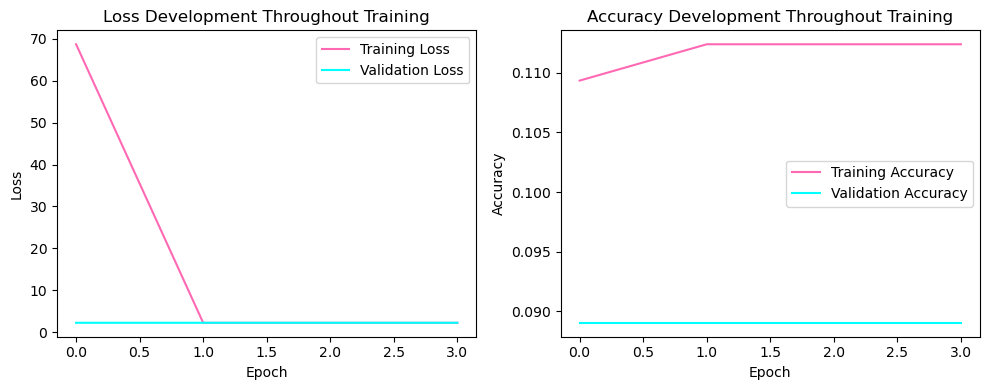

In [54]:
# Define helper function to plot model information
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs = axs.ravel()
    axs[0].plot(history.history['loss'], label='Training Loss', color='hotpink')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='cyan')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss Development Throughout Training')
    axs[0].legend()
    axs[1].plot(history.history['accuracy'], label='Training Accuracy', color='hotpink')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Accuracy Development Throughout Training')
    axs[1].legend()
    plt.tight_layout();

# Call function to plot CNN 
plot_model_history(history)

## 8: Takeaways/Notebook Conclusion <a class="anchor" id="take"></a>

As described above, this notebook contained some of our earlier EDA investigative work as well as the development of our first model. 

We this notebook read in the raw .mp3 files using the librosa library, visualized examples of each of the categories, identified a maximum length to use for the files, padded or truncated the files relative to said maximum length, then converted the files to mel spectrogram form, and an example of each category was visualized in such state.

The general process pipeline is summarized:
raw data --> data trimming --> data padding --> Mel Spectrogram --> CNN 

A basic model pipeline was also developed of a simple CNN model. The model consisted of an input, a single 2d convolution layer, a max pooling layer, flatten layer, dense layer, dropout layer, and dense activation layer. We used a softmax activation function because of the multiple categories. The baseline model was trained with a 64 batch size (pretty standard) and for four epochs. It performed very poorly, failing to even predict better than a random guess (.1). This suggests that we will need a much more complex NN than what was produced. 

The baseline model's pipeline can be summarized:
Input --> Conv2D --> MaxPool2D --> Flatten --> Dense --> Dropout(.3)--> Activation(softmax)

#### **From this, we return to our main notebook, in which we take what insights we learned from EDA and our original baseline model and apply further advanced techniques in order to attempt to develop a model that is able to classify cats' emotions from their meows.**